In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.losses import Huber
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [2]:

# Load data
df = pd.read_csv('Honda.csv', delimiter=';')

# Convert 'Date' to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df['Price'] = df['Price'].str.replace(',', '.').astype(float)


In [3]:

# Choose 'Price' as the dependent variable (output)
y = df['Price'].values

# Use only the 'Price' column as the independent variable (input)
X = df['Price'].values.reshape(-1, 1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Standardize the data
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).reshape(-1)
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).reshape(-1)



In [4]:
# Build the DNN model
model = Sequential()
model.add(Dense(64, input_dim=1, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=32, validation_split=0.2, verbose=1)


Epoch 1/50
29/29 [==============================] - 1s 20ms/step - loss: 0.5997 - val_loss: 0.2576
Epoch 2/50
29/29 [==============================] - 0s 5ms/step - loss: 0.1690 - val_loss: 0.0497
Epoch 3/50
29/29 [==============================] - 0s 5ms/step - loss: 0.0600 - val_loss: 0.0135
Epoch 4/50
29/29 [==============================] - 0s 6ms/step - loss: 0.0418 - val_loss: 0.0052
Epoch 5/50
29/29 [==============================] - 0s 8ms/step - loss: 0.0368 - val_loss: 0.0030
Epoch 6/50
29/29 [==============================] - 0s 7ms/step - loss: 0.0346 - val_loss: 0.0013
Epoch 7/50
29/29 [==============================] - 0s 7ms/step - loss: 0.0369 - val_loss: 0.0019
Epoch 8/50
29/29 [==============================] - 0s 4ms/step - loss: 0.0333 - val_loss: 9.6574e-04
Epoch 9/50
29/29 [==============================] - 0s 7ms/step - loss: 0.0333 - val_loss: 3.3263e-04
Epoch 10/50
29/29 [==============================] - 0s 6ms/step - loss: 0.0315 - val_loss: 7.5904e-05
Epoch 

In [5]:

# Predict on the test set
y_test_pred_scaled = model.predict(X_test_scaled)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).reshape(-1)

# Evaluate the model
mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

# Metrics
print("RMSE:", rmse_test)

# MAPE Calculation
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_test = mean_absolute_percentage_error(y_test, y_test_pred)
print("MAPE:", mape_test)
print("MAE:", mae_test)

# Huber Loss Calculation
huber_loss = Huber()(y_test, y_test_pred).numpy()
print("Huber Loss:", huber_loss)

10/10 [==============================] - 0s 15ms/step
RMSE: 5.426663669449009
MAPE: 0.3030040511294711
MAE: 4.406476396383697
Huber Loss: 3.9162602


In [6]:
# Predict the next 30 days
last_data_point = X_test_scaled[-1].reshape(1, -1)
forecasted_scaled = []

for _ in range(30):
    next_day_pred_scaled = model.predict(last_data_point)
    forecasted_scaled.append(next_day_pred_scaled[0, 0])

    # Update the last data point for the next prediction
    last_data_point = np.roll(last_data_point, -1)
    last_data_point[0, -1] = next_day_pred_scaled[0, 0]

# Convert the forecasted values back to the original scale
forecasted = scaler_y.inverse_transform(np.array(forecasted_scaled).reshape(-1, 1)).reshape(-1)

# Display the forecasted prices for the next 30 days
print("Forecasted Prices for the Next 30 Days:")
print(forecasted)

1/1 [==============================] - 1s 948ms/step
Forecasted Prices for the Next 30 Days:
[1390.2731 1385.1113 1380.0139 1374.98   1370.0088 1365.1008 1360.2568
 1355.4761 1350.7578 1346.1011 1341.5051 1336.9692 1332.4926 1328.0742
 1323.7136 1319.41   1315.1626 1310.9706 1306.8333 1302.75   1298.7201
 1294.7427 1290.8173 1286.943  1283.1194 1279.3457 1275.6212 1271.9454
 1268.3176 1264.7372]


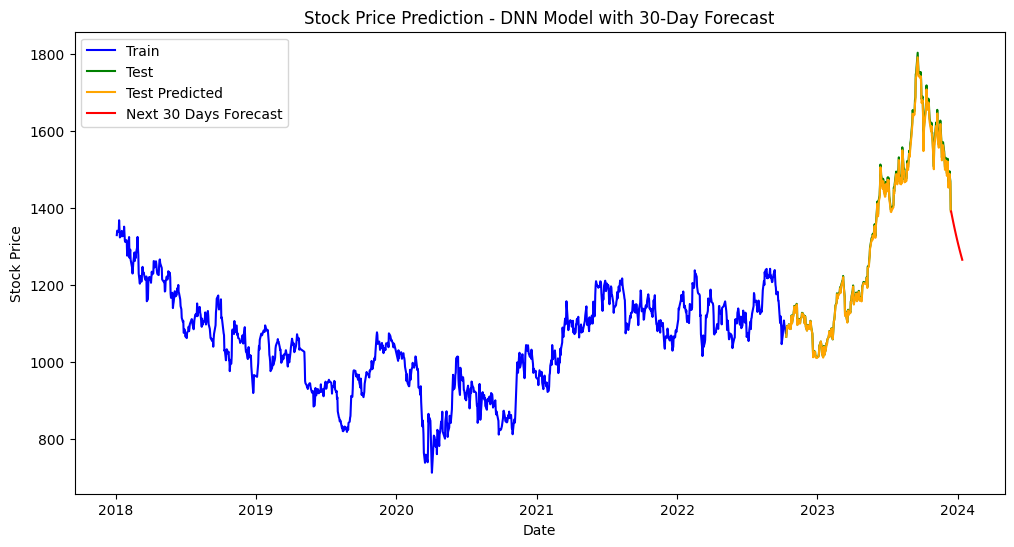

In [7]:

# Plotting the forecasted prices
plt.figure(figsize=(12, 6))
# Dữ liệu train
plt.plot(df['Date'].iloc[:len(y_train)], y_train, label='Train', color='blue')
plt.plot(df['Date'].iloc[len(y_train):len(y_train) + len(y_test)], y_test, label='Test', color='green')
plt.plot(df['Date'].iloc[len(y_train):len(y_train) + len(y_test)], y_test_pred, label='Test Predicted', color='orange')

next_30_days_index = pd.date_range(df['Date'].iloc[-1], periods=31, freq='D')[1:]
plt.plot(next_30_days_index, forecasted, label='Next 30 Days Forecast', color='red')

plt.title('Stock Price Prediction - DNN Model with 30-Day Forecast')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()